These pages explain how to get your Chrome history on your computer:
    
https://superuser.com/questions/602252/can-chrome-browser-history-be-exported-to-an-html-file
    
https://yuji.wordpress.com/2014/03/10/export-chrome-history-as-csv-spreadsheet/

Notebook of Chrome history analysis:

http://www.isabeldalessandro.com/cs234/google/notebook1.html

https://gist.github.com/dropmeaword/9372cbeb29e8390521c2

In [1]:
# see "Profile Path" on the page chrome://version/

#!cp /Users/ben/Library/Application\ Support/Google/Chrome/Default/History .

A good tutorial on how to load SQL into Pandas

https://www.dataquest.io/blog/python-pandas-databases/

The official documentation is

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_sql.html

https://pandas.pydata.org/pandas-docs/stable/io.html#sqlite-fallback

In [2]:
import pandas
import sqlite3
print('pandas',pandas.__version__)

pandas 0.23.4


In [3]:
conn = sqlite3.connect("History") # connect to the file
type(conn)

sqlite3.Connection

We need to do some math to get the date-time formats to work out.

The reason is that the timestamp in Google Chrome, named "Webkit format", defines time as the number of microseconds since January, 1601

We need to convert from the Webkit format

We can use <a href="http://strftime.org/">strftime</a> in <a href="https://en.wikipedia.org/wiki/SQL">SQL</a> to get that date:

In [4]:
query_str = "SELECT strftime('%s', '1601-01-01 00:00');" 

curr_time = pandas.read_sql_query(query_str,conn)

what do we get back?

In [5]:
type(curr_time)

pandas.core.frame.DataFrame

not surprisingly, pandas returns a dataframe.

What is the content of the dataframe?

In [6]:
curr_time

,"strftime('%s', '1601-01-01 00:00')"
0,-11644473600


What we care about is the returned value

In [7]:
curr_time.iloc[0][0]

'-11644473600'

now we do a bunch of fancy math to convert times to local

In [8]:
query_str = """SELECT 
               datetime(last_visit_time/1000000+strftime('%s', '1601-01-01 00:00:00')-(60*60*4),'unixepoch','localtime'), 
               url FROM urls ORDER BY last_visit_time DESC;"""

In [9]:
conn = sqlite3.connect("History")
hist_df = pandas.read_sql_query(query_str, conn)

In [10]:
hist_df.columns=['date_time','url']
hist_df.head()

,date_time,url
0,2020-03-11 18:51:16,https://mail.google.com/mail/u/0/#inbox/FMfcgx...
1,2020-03-11 18:51:11,http://localhost:8888/
2,2020-03-11 18:51:11,http://localhost:8888/lab?
3,2020-03-11 18:45:56,https://mail.google.com/mail/u/0/#inbox
4,2020-03-11 18:45:49,https://mail.google.com/mail/u/0/#inbox/FMfcgx...


In [11]:
hist_df.shape

(10914, 2)

Just for a check, take a look at the bottom of the dataframe (the oldest entries)

In [12]:
hist_df.tail()

,date_time,url
10909,1600-12-31 20:00:00,http://192.168.8.26:3000/d/p2nC--RZk/alert-das...
10910,1600-12-31 20:00:00,https://medlineplus.gov/
10911,1600-12-31 20:00:00,http://192.168.8.25:8081/
10912,1600-12-31 20:00:00,https://shadygrove.umbc.edu/datascience/schedu...
10913,1600-12-31 20:00:00,https://museaccount.choosemuse.com/account-set...


clearly something went wrong, but I don't know what

We will revisit later in this notebook how many invalid timestamps there are

Prior to plotting, we need to have datetime rather than strings

In [13]:
hist_df.dtypes

date_time    object
url          object
dtype: object

We need to convert the strings to datetime entries

For timestamp format, see 
http://strftime.org/

In [14]:
hist_df['date_time'] = pandas.to_datetime(hist_df['date_time'],
                                          format='%Y-%m-%d %H:%M:%S',
                                          errors='coerce')

what did we get?

In [15]:
hist_df.head()

,date_time,url
0,2020-03-11 18:51:16,https://mail.google.com/mail/u/0/#inbox/FMfcgx...
1,2020-03-11 18:51:11,http://localhost:8888/
2,2020-03-11 18:51:11,http://localhost:8888/lab?
3,2020-03-11 18:45:56,https://mail.google.com/mail/u/0/#inbox
4,2020-03-11 18:45:49,https://mail.google.com/mail/u/0/#inbox/FMfcgx...


In [16]:
hist_df.tail()

,date_time,url
10909,NaT,http://192.168.8.26:3000/d/p2nC--RZk/alert-das...
10910,NaT,https://medlineplus.gov/
10911,NaT,http://192.168.8.25:8081/
10912,NaT,https://shadygrove.umbc.edu/datascience/schedu...
10913,NaT,https://museaccount.choosemuse.com/account-set...


In [17]:
hist_df['date_time'].max()

Timestamp('2020-03-11 18:51:16')

In [18]:
hist_df['date_time'].min()

Timestamp('2018-10-31 16:51:42')

how many entries are missing a timestamp?

In [19]:
pandas.isnull(hist_df['date_time']).sum()

57

Let's keep the NaT and see if we can plot the data

In [20]:
import matplotlib.pyplot as plt

Source:
https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates

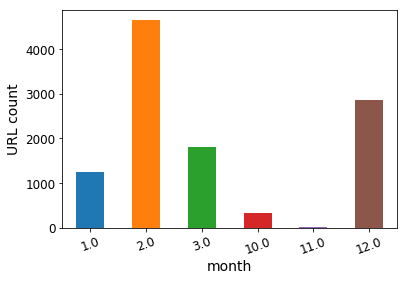

In [21]:
hist_df["date_time"].groupby(hist_df["date_time"].dt.month).count().plot(kind="bar")
plt.xlabel('month', fontsize=14)
plt.ylabel('URL count', fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=20, fontsize=12) # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.show()

In [27]:
# sanity check:
# URLs per day?
4000/30

133.33333333333334

In case 1 or more of the months shows up in multiple years, we need to apply multiple groupby operations

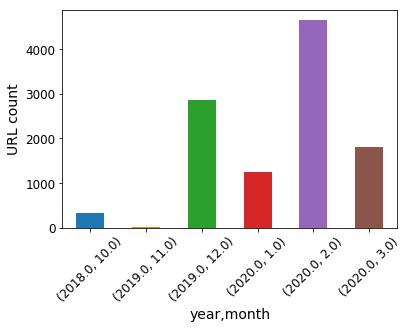

In [23]:
hist_plot = hist_df["date_time"].groupby([hist_df["date_time"].dt.year, 
                                          hist_df["date_time"].dt.month]).count().plot(kind="bar")
plt.xlabel('year,month', fontsize=14)
plt.ylabel('URL count', fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=45, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.show()

What was previously attributed to "Oct" we can see is actually "Oct 2019" and "Oct 2018"

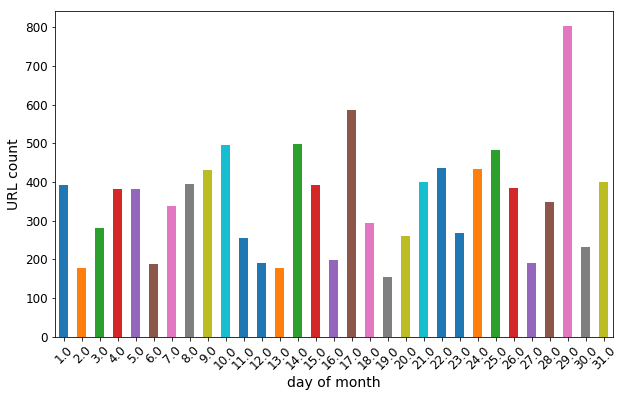

In [24]:
fig = plt.figure(figsize=(10,6))
#plt.figure(figsize=(20,20))

hist_df["date_time"].groupby(hist_df["date_time"].dt.day).count().plot(kind="bar")

plt.xlabel('day of month', fontsize=14)
plt.ylabel('URL count', fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=45, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.show()

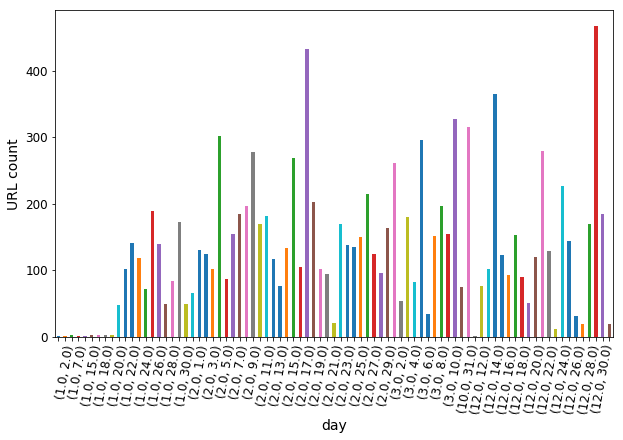

In [25]:
fig = plt.figure(figsize=(10,6))

hist_plot = hist_df["date_time"].groupby([hist_df["date_time"].dt.month, hist_df["date_time"].dt.day]).count().plot(kind="bar")
# https://stackoverflow.com/questions/20337664/cleanest-way-to-hide-every-nth-tick-label-in-matplotlib-colorbar
for label in hist_plot.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.xlabel('day', fontsize=14)
plt.ylabel('URL count', fontsize=14)

plt.setp(plt.gca().get_xticklabels(), rotation=80, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)

plt.show()

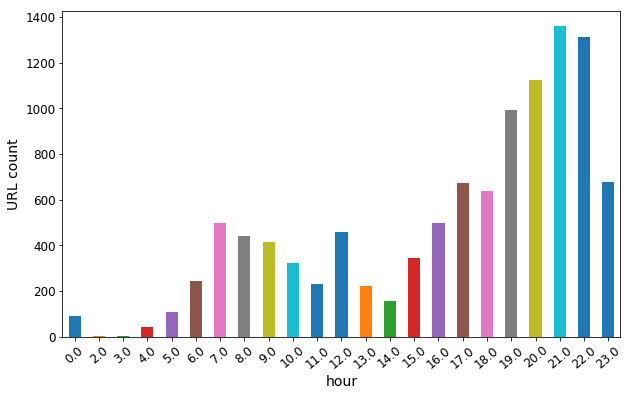

In [26]:
fig = plt.figure(figsize=(10,6))

hist_df["date_time"].groupby(hist_df["date_time"].dt.hour).count().plot(kind="bar")
plt.xlabel('hour', fontsize=14)
plt.ylabel('URL count', fontsize=14)

plt.setp(plt.gca().get_xticklabels(), rotation=40, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)


plt.show()